# Naive RAG to LangGraph

### 환경설정

In [15]:
%%capture

# update or install the necessary libraries

%pip install langgraph
%pip install --upgrade \
    langchain==0.3.24 \
    langchain-openai==0.3.14
%pip install -U langsmith
%pip install --upgrade python-dotenv

In [13]:
from dotenv import load_dotenv

load_dotenv()

True

### LangSmith 설정

In [14]:
from langsmith import traceable
from langchain.schema import HumanMessage
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-3.5-turbo")

@traceable  # LangSmith 추적용 데코레이터
def pipeline(user_input: str):
    result = llm.invoke([HumanMessage(content=user_input)])
    return result.content  # or result if full object needed

print(pipeline("Hello, world!"))

Hello! How can I assist you today?


### 기본 PDF 기반 Retrieval Chain 생성 

In [ ]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import ElasticsearchStore
from langchain_core.vectorstores import VectorStoreRetriever
from typing import List
from langchain_core.documents import Document
from langchain_text_splitters import CharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
import os 


class DataPipeline:
  def __init__(self):
    self.file_path = "/Users/lines/sources/00_company/lines-rag-processor-python/load/use_case/medical_study_books_0_10.pdf"
    self.data_loader = PyPDFLoader(self.file_path)
    self.embeddings = OpenAIEmbeddings(model="text-embedding-3-large", dimensions=1024)
    self.elastic_store = ElasticsearchStore(
        embedding=self.embeddings,
        es_url=os.getenv("ES_URL"),
        es_user=os.getenv("ES_USER"),
        es_password=os.getenv("ES_PASSWORD"),
        index_name=os.getenv("INDEX_NAME")
    )
    

  def load(self) -> List[Document]:
    pages = []
    for page in self.data_loader.load():
      pages.append(page)

  
  def splits(self, documents:List[Document]) -> List[Document]:
    text_splitter = CharacterTextSplitter(
        separator="\n\n",
        chunk_size=1000,
        chunk_overlap=200,
        length_function=len,
        is_separator_regex=False,
    )

    docs = text_splitter.split_documents(documents)
  
    return docs
  
  def store(self, documents:List[Document]):
    instance_from_documents = self.elastic_store.from_documents(
        documents=documents,
        embedding=self.embeddings,
        index_name=os.getenv("INDEX_NAME"),
        es_url=os.getenv("ES_URL"),
    )

    instance_from_documents.client.indices.refresh(index=os.getenv("INDEX_NAME"))


  def retriever(self) -> VectorStoreRetriever:
        ## Setup the Retriever using an In-memory store
    ## , which can retrieve documents based on a query
    retriever = self.elastic_store.as_retriever()

    return retriever


### Langgraph로 구현 

#### State 정의 

- State : Graph의 노드와 노드 간 공유하는 상태를 정의합니다 
- 일반적으로 TypedDict 형식을 사용합니다. 

In [16]:
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages

class GraphState(TypedDict):
  question: Annotated[str, "Question"]
  context: Annotated[str, "Context"]
  answer: Annotated[str, "Answer"]
  messages: Annotated[list, add_messages]

#### Node 정의 

- Nodes: 각 단계를 처리하는 노드입니다. 보통은 Python 함수로 구현합니다. 입력곽 출력이 상태(State) 값입니다. 
- State를 입력으로 받아 정의된 로직을 수행한 후 업데이트된 State를 반환합니다. 

In [ ]:
def retrieve_document(state: GraphState) -> GraphState:
  latest_question = state["question"]

  # retreive from vector db for rag

  # format docs

  return { "context" : "" }

def llm_answer(state: GraphState) -> GraphState:
  latest_question = state["question"]

  context = state["context"]

  # history handling 

  # answer handling

  return {
    "answer" : "my answer", 
    "messages" : [("user", latest_question), ("assistant", "response")]
  }



#### 그래프 생성 

- Edges : 현재 State를 기반으로 다음에 실행할 Node를 결정하는 Python 함수 
  - 일반 엣지
  - 조건부 엣지

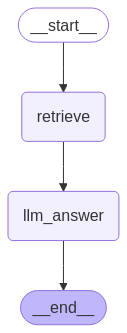

In [26]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display

graph = StateGraph(GraphState)
graph.add_node("retrieve", retrieve_document)
graph.add_node("llm_answer", llm_answer)

graph.add_edge("retrieve", "llm_answer")
graph.add_edge("llm_answer", END)

graph.set_entry_point("retrieve")

memory = MemorySaver()

app = graph.compile(checkpointer=memory)

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)
    pass